# Анализ и классификация рисков для здоровья матери

Короткая русифицированная версия: https://www.kaggle.com/code/corazon17/mhr-analysis-and-classification-90-15-accuracy

# Выявление проблемы

Многие беременные женщины умирают от осложнений беременности из-за отсутствия достаточной информации об охране здоровья матери во время беременности и после беременности. Во время беременности необходимо следить за каждым моментом для здорового развития плода и обеспечения безопасных родов. Надлежащий уход и диагностика в начале беременности могут помочь снизить предотвратимую смертность беременных женщин и новорожденных, особенно в сельской местности.

В этой тетради мы проанализируем несколько атрибутов, влияющих на здоровье беременных женщин. Мы также создадим модель машинного обучения для прогнозирования уровня риска для здоровья беременных женщин.

# Импорт пакетов и набора данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split as split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
data = pd.read_csv(r'pregnant.csv')
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


Age - Возраст

SystolicBP - Верхнее значение артериального давления в мм рт.ст.

DiastolicBP - Нижнее значение артериального давления в мм рт.ст.

BS - Уровень глюкозы в крови в пересчете на молярную концентрацию, ммоль/л

BodyTemp - температура тела по Фаренгейту

HeartRate - Нормальная частота сердечных сокращений в состоянии покоя в ударах в минуту.

RiskLevel - Прогнозируемый уровень интенсивности риска во время беременности


# Уровень риска

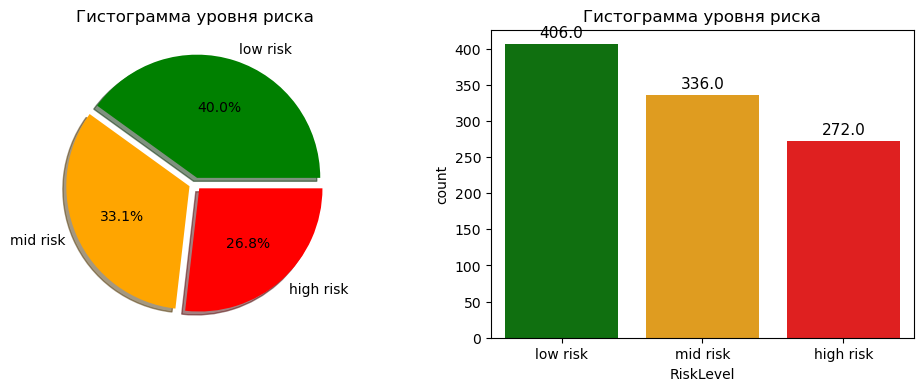

In [6]:
p_colors = ['green', 'orange', 'red']
risk_order = ["low risk", "mid risk", "high risk"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

data["RiskLevel"].value_counts().plot(kind="pie", labels=risk_order, colors=p_colors, explode=[0.05, 0.05,  0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title("Гистограмма уровня риска")
ax[0].set_ylabel('')

count = sns.countplot(x="RiskLevel", data=data, ax=ax[1], order=risk_order, palette=p_colors)
for bar in count.patches:
    count.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
ax[1].set_title("Гистограмма уровня риска")
plt.show()

Похоже, что большинство беременных женщин в этом наборе данных в основном имеют низкий риск для здоровья. Из 1014 наблюдений у 406 (40%) беременных низкий риск, у 336 (33,1%) средний риск, у 272 (26,8%) высокий риск. Мы изучим данные, чтобы получить больше информации и понять, почему у беременных женщин разный риск для здоровья. Мы постараемся проверить каждую переменную, которая может на нее повлиять. Давайте рассмотрим его один за другим.

# Разработка функций и очистка данных

## Обработка выбросов

Как мы знаем из предыдущего анализа, в этом наборе данных есть несколько переменных, которые имеют выбросы, но даже в этом случае большинство этих значений по-прежнему имеют смысл в реальной жизни. Единственная переменная, которая имеет выброс с необоснованным значением, — это HeartRate. В этой переменной есть два наблюдения со значением частоты сердечных сокращений 7 ударов в минуту (ударов в минуту). Нормальная частота сердечных сокращений в покое для взрослых колеблется от 60 до 100 ударов в минуту, а самая низкая зарегистрированная частота сердечных сокращений в состоянии покоя в истории человечества составляла 25 ударов в минуту. Поэтому мы отбросим эти 2 записи со значением частоты сердечных сокращений 7, потому что это значение не имеет никакого смысла и, скорее всего, является ошибкой ввода.

Мы не будем хранить обработанные данные в исходной переменной, а вместо этого будем хранить их в новой переменной, чтобы мы могли сравнить их с исходными данными.

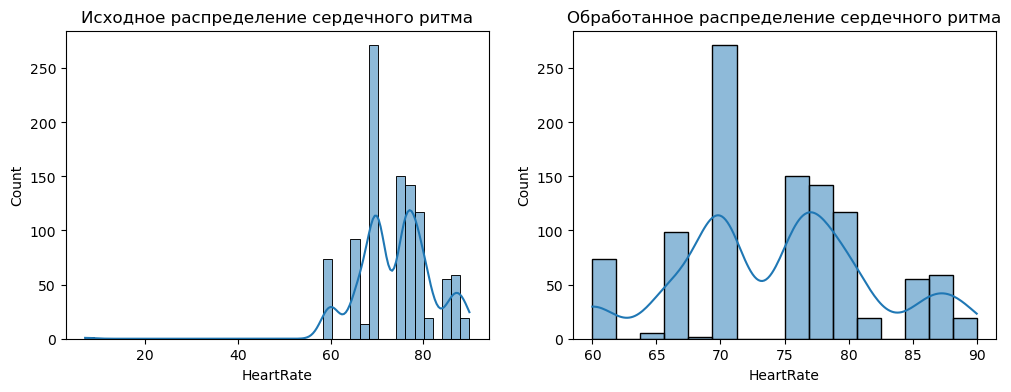

In [44]:
data_proc = data.drop(data.index[data.HeartRate == 7])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=data, x="HeartRate", kde=True, ax=ax[0])
sns.histplot(data=data_proc, x="HeartRate", kde=True, ax=ax[1])
ax[0].set_title("Исходное распределение сердечного ритма")
ax[1].set_title("Обработанное распределение сердечного ритма")
plt.show()

## Удаление ненужных функций

Проведя несколько анализов переменных-предикторов, мы пришли к выводу, что переменная HeartRate менее полезна для определения рисков для здоровья беременных женщин. Таким образом, можно безопасно удалить эту переменную.

In [45]:
data_proc = data_proc.drop(["HeartRate"], axis=1)

Вы можете подумать, почему мы удаляем записи с выбросом в переменной HeartRate, если в конце мы удалим эту переменную. Ответ заключается в том, что в нем есть ошибка ввода, поэтому записи могут быть незаконными. Может случиться так, что данная метка также неверна, поэтому она будет вводить в заблуждение процесс обучения, что сделает модель менее точной.

# Построение модели

## Разделение набора данных

Мы разделим наш набор данных на 80% данных поезда и 20% тестовых данных.

In [46]:
# Original Dataset
X = data.drop("RiskLevel", axis=1)
y = data.RiskLevel
x_train, x_test, y_train, y_test = split(X, y, test_size=0.2, random_state=1)

# Processed Dataset
X_proc = data_proc.drop("RiskLevel", axis=1)
y_proc = data_proc.RiskLevel
x_train_proc, x_test_proc, y_train_proc, y_test_proc = split(X_proc, y_proc, test_size=0.2, random_state=1)

print(f"Исходный датасет {x_train.shape[0]} train data and {x_test.shape[0]} test data\n")
print(f"Предобработанный датасет {x_train_proc.shape[0]} train data and {x_test_proc.shape[0]} test data")

Исходный датасет 811 train data and 203 test data

Предобработанный датасет 809 train data and 203 test data


## Модель классификации зданий

В этом случае мы будем использовать алгоритм Random Forest для построения нашей модели. Случайный лес содержит множество деревьев решений, представляющих отдельный экземпляр классификации входных данных. Техника случайного леса рассматривает экземпляры по отдельности, принимая за выбранный прогноз тот, у которого больше всего голосов. Таким образом, случайный лес позволяет любым классификаторам со слабыми корреляциями создать сильный классификатор.

Мы выбираем Random Forest, потому что это один из самых точных доступных алгоритмов обучения, и время его обучения мало. Кроме того, Random Forest может работать с набором данных, который имеет значения признаков с разным масштабом, поэтому нам не нужно выполнять нормализацию/масштабирование признаков.

In [47]:
# Using original dataset
rf = RandomForestClassifier(random_state=100)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(f"Accuracy исходного датасета: {accuracy_score(y_test, y_pred)}")

# Using processed dataset
rf2 = RandomForestClassifier(random_state=100)
rf2.fit(x_train_proc, y_train_proc)
y_pred = rf2.predict(x_test_proc)
print(f"Accuracy предобработанного: {accuracy_score(y_test_proc, y_pred)}")

Accuracy исходного датасета: 0.8669950738916257
Accuracy предобработанного: 0.8916256157635468


Вот так. Мы получили на 2,46% больше точности тестовых данных с нашим обработанным набором данных. Это показывает, что наша модель лучше обобщает обработанный набор данных для наших тестовых данных. Мало того, Random Forest также имеет несколько гиперпараметров, которые мы можем настроить, чтобы получить модель с еще лучшим обобщением.

## Настройка гиперпараметров

Мы попробуем настроить 2 параметра Random Forest, а именно n_estimators и критерий. n_estimator — это количество деревьев в лесу, а критерий — это функция для измерения качества разделения. Для этого мы будем использовать GridSearchCrossValidation с количеством сгибов до 10.

In [48]:
params = {
    "n_estimators": [10, 20, 50, 100],
    "criterion": ["gini", "entropy"]
}
rf = RandomForestClassifier(random_state=100)
grid = GridSearchCV(rf, params, cv=10)
grid.fit(x_train_proc, y_train_proc)
print("Лучшие гиперпараметры:", grid.best_params_)

Лучшие гиперпараметры: {'criterion': 'gini', 'n_estimators': 50}


In [49]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")[["params", "mean_test_score", "rank_test_score"]]

,params,mean_test_score,rank_test_score
2,"{'criterion': 'gini', 'n_estimators': 50}",0.831867,1
3,"{'criterion': 'gini', 'n_estimators': 100}",0.830648,2
7,"{'criterion': 'entropy', 'n_estimators': 100}",0.828179,3
6,"{'criterion': 'entropy', 'n_estimators': 50}",0.828164,4
1,"{'criterion': 'gini', 'n_estimators': 20}",0.823241,5
5,"{'criterion': 'entropy', 'n_estimators': 20}",0.822006,6
4,"{'criterion': 'entropy', 'n_estimators': 10}",0.818210,7
0,"{'criterion': 'gini', 'n_estimators': 10}",0.808302,8


In [50]:
y_pred = grid.predict(x_test_proc)
print(f"Accuracy предобработанного датасета: {accuracy_score(y_test_proc, y_pred)}")

Accuracy предобработанного датасета: 0.9014778325123153


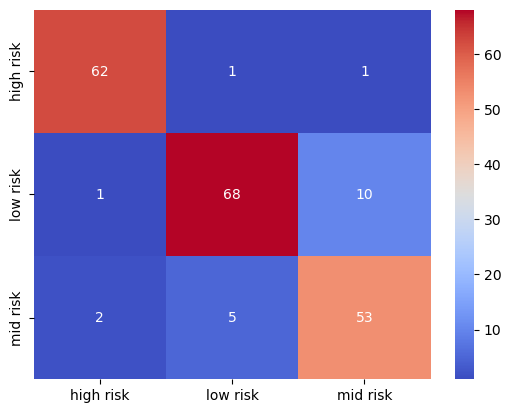

In [51]:
labels = np.unique(y_pred)
sns.heatmap(confusion_matrix(y_test_proc, y_pred), annot=True, xticklabels=labels, yticklabels=labels, cmap="coolwarm")
plt.show()

Вот и все. После настройки гиперпараметров мы получили лучшее значение для критерия «джини», а n_estimators равно 50. При таком значении параметра точность полученной модели увеличилась почти на 1% по сравнению с тестовыми данными. Хоть это и не много, но все же улучшение от получившейся модели есть.

# Заключение

Проведя некоторый анализ этого набора данных, мы можем сделать вывод, что BS или уровень глюкозы в крови является наиболее важной переменной в определении уровня здоровья беременных женщин. Беременные женщины с высоким уровнем глюкозы в крови, как правило, имеют высокий риск для здоровья. Более 75% беременных с BS 8 и более имеют высокий риск для здоровья. BS также имеет относительно сильную положительную корреляцию с возрастом, систолическим и диастолическим АД, поэтому беременным женщинам с высоким возрастом, систолическим и диастолическим АД следует быть бдительными. Возраст также является довольно важной переменной, поскольку риски для здоровья беременных женщин, по-видимому, начинают увеличиваться, начиная с 25-летнего возраста. Для систолического и диастолического АД эти две переменные действительно имеют сильную взаимосвязь, о чем свидетельствует значение коэффициента корреляции, равное 0,79. Что касается BodyTemp, эта переменная на самом деле не дает много информации, потому что более 79% от общего значения составляет 98F. Но из этой переменной мы знаем, что беременные женщины с температурой тела выше 98,4 F, как правило, имеют больший риск для здоровья. И последний параметр — частота сердечных сокращений, наименее значимая переменная для определения уровня здоровья беременных женщин.

И, наконец, мы можем построить нашу модель классификации, используя алгоритм Random Forest для этого набора данных. С исходным набором данных мы получаем точность 86,7%. Но после того, как мы проделаем некоторую инженерию функций и очистку данных, удалив выбросы и ненужную переменную, точность, которую мы получим, возрастет до 89,16%. Это показывает, что наша модель лучше обобщается с нашим обработанным набором данных. Мы также выполнили настройку гиперпараметров, чтобы получить лучший гиперпараметр для алгоритма Random Forest. Используя лучшие из полученных гиперпараметров, модель способна обеспечить более высокую точность, которая составляет 90,15%.